## LipSDP (Lipschitz Constant Estimation via Semi-Definite Programming) using CVXPY

Here, we aim to find an estimation of the Lipschitz constant for a single layer Neural Network with the ReLU Activation Function. We provide estimates using two different functions and compare the two. While the first does it by computing the **Spectral Norm** of the weight matrices and multiplying them to obtain the lipschitz constant, the second one does it using the **DCP System of CVXPY by deploying LipSDP** (Details of its working are mentioned below).

In [1]:
# importing necessary libraries
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

We consider a single layer Neural Network define by the function $f(X)=W^{1} {\phi}(W^{0}x + b^{0}) + b^{1}$ where ${\phi}$ is the ReLU Activation Function

the function: *trivial_lipschitz_constant* computes the lipschitz constant simply by computing the **Spectral Norm** of the weights since it is a single layer neural network 

In [2]:
def trivial_lipschitz_constant(W0, W1):
    
    # computes 2-norm also known as Spectral norm
    
    norm_W0 = np.linalg.norm(W0, ord=2)
    norm_W1 = np.linalg.norm(W1, ord=2)
    lipschitz_constant = norm_W0 * norm_W1
    
    return lipschitz_constant

In [3]:
# test case 1:

# weight matrices
W0 = np.array([[1, 0], [0, 1]]) 
W1 = np.array([[1, 0], [0, 1]])

lipschitz_constant = trivial_lipschitz_constant(W0, W1)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 1.0


In [4]:
# test case 2:

# weight matrices 
W0 = np.array([[62, 10], [-19, 10]]) 
W1 = np.array([[1, 0], [0, 1]])  


lipschitz_constant = trivial_lipschitz_constant(W0, W1)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 65.19698634456758


In [5]:
# test case 3:

# weight matrices
W0 = np.array([[1020, 35783], [3, 371]]) 
W1 = np.array([[1, 0], [0, 1]])

lipschitz_constant = trivial_lipschitz_constant(W0, W1)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 35799.45644372084


In [6]:
# test case 4:

# weight matrices
W0 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) 
W1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) 

lipschitz_constant = trivial_lipschitz_constant(W0, W1)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 1.0


In [7]:
# test case 5:

# weight matrices
W0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
W1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

lipschitz_constant = trivial_lipschitz_constant(W0, W1)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 1.0


the function: *lipschitz_constant_2* uses the CVXPY **Disciplined Convex Programming (DCP)** system to solve the given convex optimization problem

### We use the following theorem to formulate the Semi Definite Program: 

Details of the Theorem can be found in this paper: https://arxiv.org/abs/1906.04893v2
[Fazlyab, M., Robey, A., Hassani, H., Morari, M., & Pappas, G. J. (2019). Efficient and Accurate Estimation of Lipschitz Constants for Deep Neural Networks. ArXiv. /abs/1906.04893]

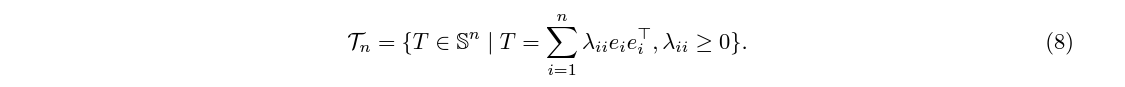

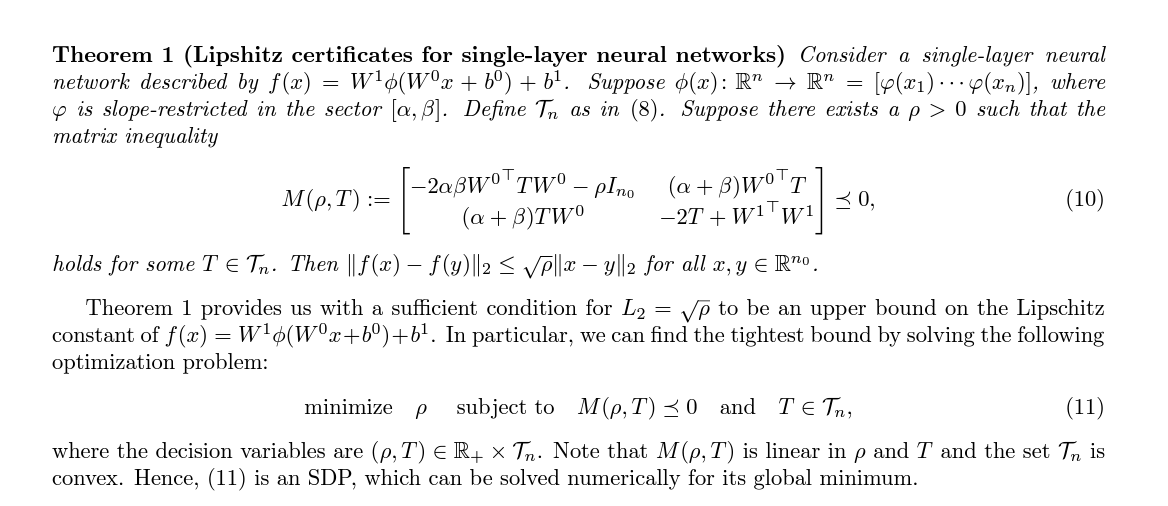

In [8]:
def lipsdp_lipschitz_constant(W0, W1, alpha, beta, solver):
    
    n = W0.shape[1]  # number of columns in W0 (hidden layer size)
    m = W1.shape[0]  # number of rows in W1 (number of neurons in the hidden layer)

    # defining the decision variable
    rho = cp.Variable(nonneg=True)
    diag_entries = cp.Variable(m, nonneg=True)
    Tm = cp.diag(diag_entries)

    # defining the matrix inequality M(ρ, Tm)
    M_upper_left = -2 * alpha * beta * (W0.T @ Tm @ W0) - rho * np.eye(W0.shape[0])
    M_upper_right = (alpha + beta) * (W0.T @ Tm)
    M_lower_left = (alpha + beta) * (Tm @ W0)
    M_lower_right = -2 * Tm + W1.T @ W1

    # constructing the block matrix M(ρ, Tm)
    M = cp.bmat([
        [M_upper_left, M_upper_right],
        [M_lower_left, M_lower_right]
    ])

    # defining the constraints
    # M(ρ, Tm) is negative semidefinite and Tm has only positive diagonal entries
    constraints = [M << 0, diag_entries >= 0]

    # defining the objective function
    objective = cp.Minimize(rho)

    # defining the problem
    problem = cp.Problem(objective, constraints)
    
    # solving the problem
    problem.solve(solver=solver) # we will use SCS, SDPA, CLARABEL, CVXOPT 
    
    if problem.status not in ["infeasible", "unbounded"]:
        lipschitz_constant = np.sqrt(rho.value)
        return lipschitz_constant
    else:
        return None

**Note:** As we can see in the above theorem and function, the lipschitz constant does not depend on $b^{0}$ and $b^{1}$. 

We set the values of alpha and beta considering the activation function is slope restricted between [${\alpha}, {\beta}$].


In [9]:
alpha = 0.0  # setting alpha = 0
beta = 1.0   # setting beta = 1

In [10]:
# we will iterate over multiple solvers for Convex Optimization SDP problems
solvers = [cp.SCS, cp.CVXOPT, cp.SDPA, cp.CLARABEL] 

In [11]:
# function for plotting the results

def plotfig(lower_ylim, upper_ylim):
    plt.figure(figsize=(10, 6))
    plt.bar(solvers, lip_constants, color='skyblue', label='LipSDP Computed')
    plt.axhline(y=trivial_lip_const, color='r', linestyle='-', label='Trivial Lipschitz Constant')

    plt.xlabel('Solvers')
    plt.ylabel('Lipschitz Constant')
    plt.title('Lipschitz Constants Computed by Different Solvers')
    plt.ylim(lower_ylim, upper_ylim)
    plt.legend()
    plt.grid(True)
    plt.show()
    return

Trivial Lipschitz Constant: 1.0
Running LipSDP...
Lipschitz constant computed by deploying LipSDP:
On using SCS solver :  1.0000025938862902
On using CVXOPT solver :  0.9999999957440362
On using SDPA solver :  1.0000000069196948
On using CLARABEL solver :  1.0000000004201228


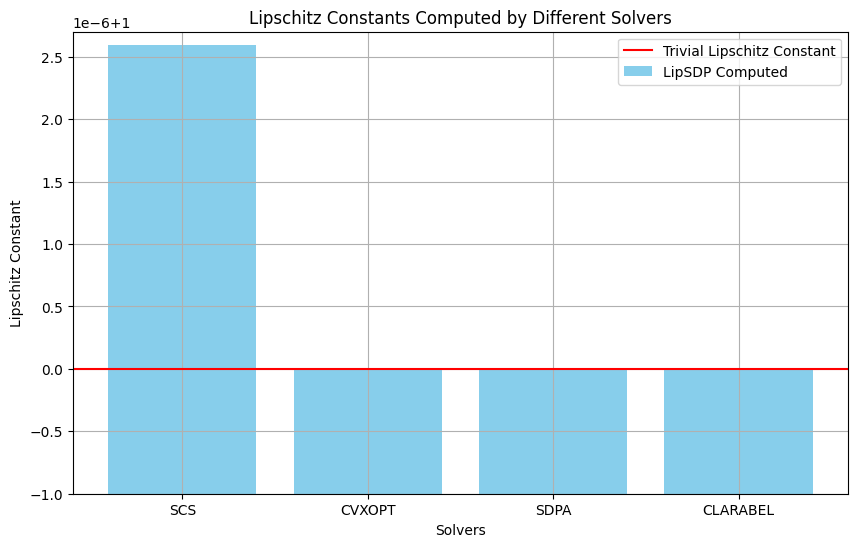

In [12]:
# test case 1:

# weight matrices
W0 = np.array([[1, 0], [0, 1]]) 
W1 = np.array([[1, 0], [0, 1]])

# computing the trivial Lipschitz constant
trivial_lip_const = trivial_lipschitz_constant(W0, W1)

# computing the Lipschitz constant using LipSDP with different solvers
lip_constants = []
print(f"Trivial Lipschitz constant: {trivial_lip_const}")
print("Running LipSDP...")
print("Lipschitz constant computed by deploying LipSDP:")
for solver in solvers:
    lipschitz_constant = lipsdp_lipschitz_constant(W0, W1, alpha, beta, solver)
    lip_constants.append(lipschitz_constant)
    print(f"On using {solver} solver : ", lipschitz_constant)
    
# plotting the results    
plotfig(0.999999, 1.0000027)

Trivial Lipschitz Constant: 65.19698634456758
Running LipSDP...
Lipschitz constant computed by deploying LipSDP:
On using SCS solver :  64.61611223542766
On using CVXOPT solver :  65.19698621959478
On using SDPA solver :  nan
On using CLARABEL solver :  65.19698599846085


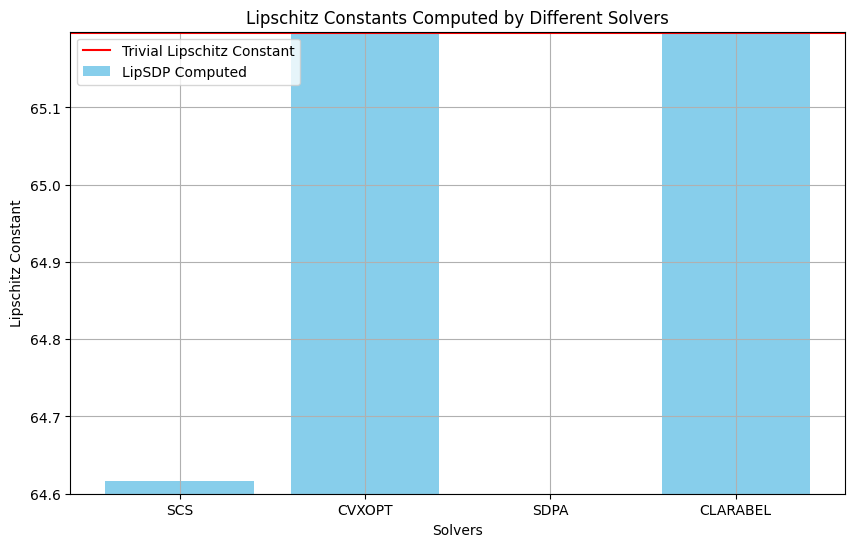

In [17]:
# test case 2:

# weight matrices
W0 = np.array([[62, 10], [-19, 10]]) 
W1 = np.array([[1, 0], [0, 1]])  

# computing the trivial Lipschitz constant
trivial_lip_const = trivial_lipschitz_constant(W0, W1)

# computing the Lipschitz constant using LipSDP with different solvers
lip_constants = []
print(f"Trivial Lipschitz constant: {trivial_lip_const}")
print("Running LipSDP...")
print("Lipschitz constant computed by deploying LipSDP:")
for solver in solvers:
    lipschitz_constant = lipsdp_lipschitz_constant(W0, W1, alpha, beta, solver)
    if lipschitz_constant is None:
        lipschitz_constant = np.nan 
    lip_constants.append(lipschitz_constant)
    print(f"On using {solver} solver : ", lipschitz_constant)
    
# plotting the results    
plotfig(64.6, 65.198)

Trivial Lipschitz Constant: 35799.45644372084
Running LipSDP...
Lipschitz constant computed by deploying LipSDP:
On using SCS solver :  554.6152199638269
On using CVXOPT solver :  nan
On using SDPA solver :  nan
On using CLARABEL solver :  35799.51246695426


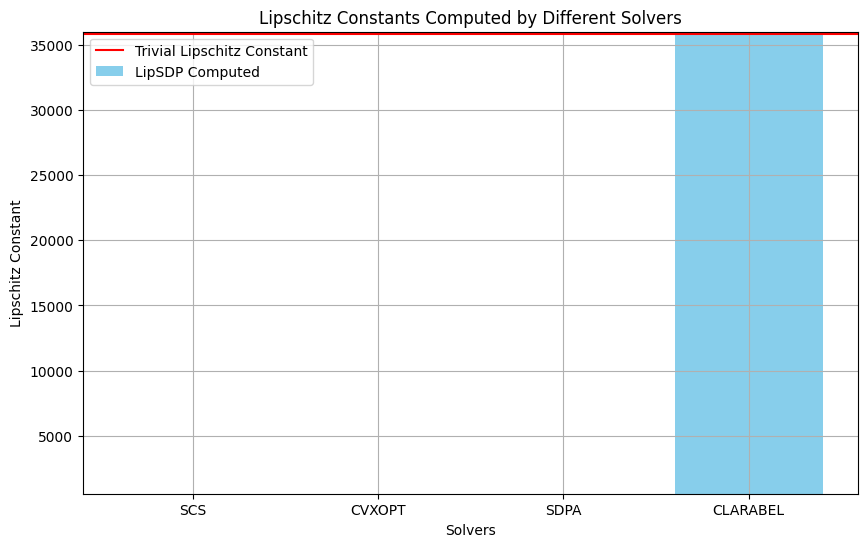

In [14]:
# test case 3:

# weight matrices
W0 = np.array([[1020, 35783], [3, 371]]) 
W1 = np.array([[1, 0], [0, 1]]) 

# computing the trivial Lipschitz constant
trivial_lip_const = trivial_lipschitz_constant(W0, W1)

# computing the Lipschitz constant using LipSDP with different solvers
lip_constants = []
print(f"Trivial Lipschitz constant: {trivial_lip_const}")
print("Running LipSDP...")
print("Lipschitz constant computed by deploying LipSDP:")
for solver in solvers:
    lipschitz_constant = lipsdp_lipschitz_constant(W0, W1, alpha, beta, solver)
    if lipschitz_constant is None:
        lipschitz_constant = np.nan 
    lip_constants.append(lipschitz_constant)
    print(f"On using {solver} solver : ", lipschitz_constant)
    
# plotting the results    
plotfig(550, 36000)

Trivial Lipschitz Constant: 1.0
Running LipSDP...
Lipschitz constant computed by deploying LipSDP:
On using SCS solver :  1.00001518420924
On using CVXOPT solver :  1.0000000010335375
On using SDPA solver :  1.0000000108153435
On using CLARABEL solver :  1.0000000013270796


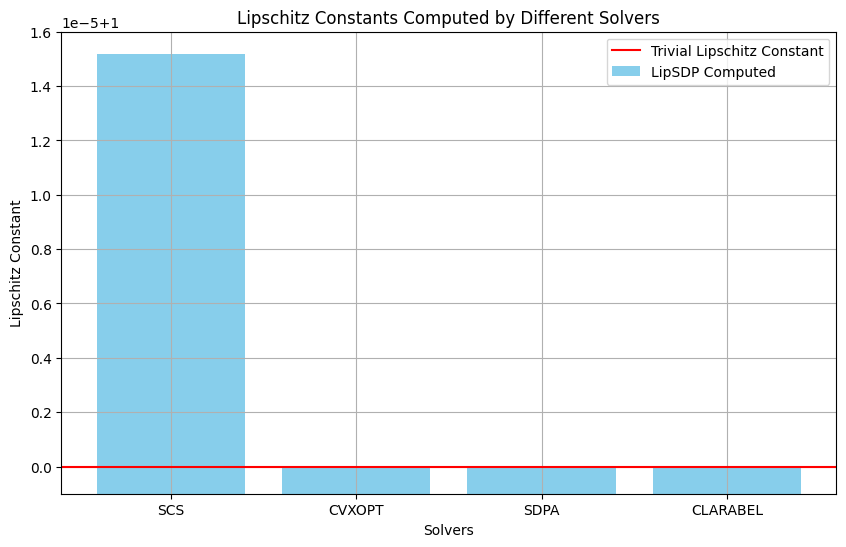

In [15]:
# test case 4:

# weight matrices
W0 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) 
W1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) 
    
# computing the trivial Lipschitz constant
trivial_lip_const = trivial_lipschitz_constant(W0, W1)

# computing the Lipschitz constant using LipSDP with different solvers
lip_constants = []
print(f"Trivial Lipschitz constant: {trivial_lip_const}")
print("Running LipSDP...")
print("Lipschitz constant computed by deploying LipSDP:")
for solver in solvers:
    lipschitz_constant = lipsdp_lipschitz_constant(W0, W1, alpha, beta, solver)
    if lipschitz_constant is None:
        lipschitz_constant = np.nan 
    lip_constants.append(lipschitz_constant)
    print(f"On using {solver} solver : ", lipschitz_constant)
    
# plotting the results    
plotfig(0.999999, 1.000016)

Trivial Lipschitz Constant: 1.0
Running LipSDP...
Lipschitz constant computed by deploying LipSDP:
On using SCS solver :  1.0000004858875091
On using CVXOPT solver :  1.0000000049473499
On using SDPA solver :  1.000000015084941
On using CLARABEL solver :  1.0000000030201042


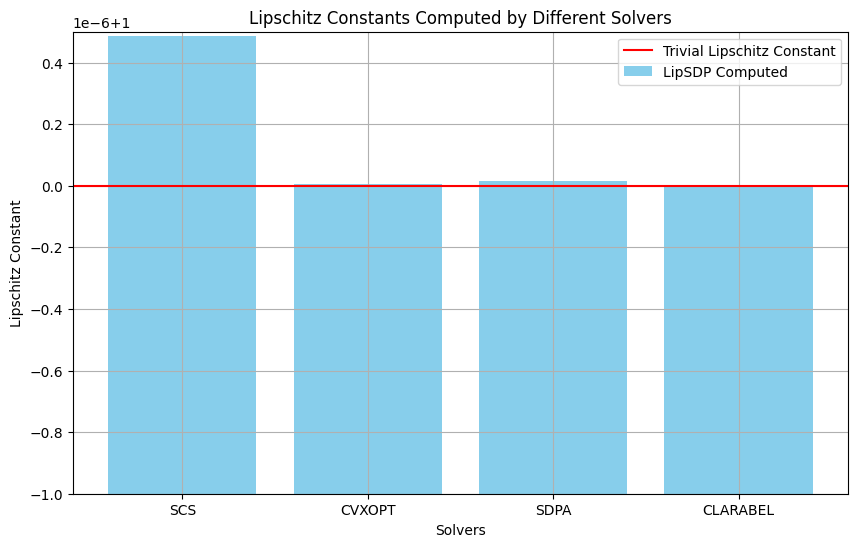

In [16]:
# test case 5:

# weight matrices
W0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
W1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    
# computing the trivial Lipschitz constant
trivial_lip_const = trivial_lipschitz_constant(W0, W1)

# computing the Lipschitz constant using LipSDP with different solvers
lip_constants = []
print(f"Trivial Lipschitz constant: {trivial_lip_const}")
print("Running LipSDP...")
print("Lipschitz constant computed by deploying LipSDP:")
for solver in solvers:
    lipschitz_constant = lipsdp_lipschitz_constant(W0, W1, alpha, beta, solver)
    if lipschitz_constant is None:
        lipschitz_constant = np.nan 
    lip_constants.append(lipschitz_constant)
    print(f"On using {solver} solver : ", lipschitz_constant)
    
# plotting the results    
plotfig(0.999999, 1.0000005)

**Conclusion**: Hence, we conclude that the SCS and the CLARABEL solver give the most optimized results. 